In [50]:
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
from LowLevelModules.PyAPT import APTMotor
from LowLevelModules.NIdaqAPD import APDCounter
from LowLevelModules.GeneralFunctions import *
import time
import ipywidgets as widgets
from IPython.display import display

# initialize the HWP motors
hwp = {}
hwp['Collection'] = APTMotor(83853557, HWTYPE=31)
hwp['Collection'].setVelocityParameters(0, 25, 25)
print("HWP in collection ready to use")
hwp['Absorption'] = APTMotor(83857433, HWTYPE=31)
hwp['Absorption'].setVelocityParameters(0, 25, 25)
hwp['Absorption'].mAbs(0)
print("HWP in absorption ready to use and initialized to zero")
#calibration 3/7/19. Collection polarizer GL10 offset by 21.5 degrees, no pellicule in path
#calibration 3/22/19. Collection polarizer Lin Pol offset by 67 degrees, no pellicule in path
offset_col = 45

HWP in collection ready to use
HWP in absorption ready to use and initialized to zero


In [2]:
# make some checkboxes for easy selection of different parameters
savedata_choice = widgets.Checkbox(value=False, description='Save data')
mode_choice = widgets.RadioButtons(options=['Absorption', 'Collection'], value='Collection', description='HWP choice')
display(savedata_choice)
display(mode_choice)

Checkbox(value=False, description='Save data')

RadioButtons(description='HWP choice', index=1, options=('Absorption', 'Collection'), value='Collection')

# Move HWP to a given position

In [56]:
go_to_position = 125
offset = offset_col if mode_choice.value == 'Collection' else 0
hwp[mode_choice.value].mAbs((go_to_position+offset)/2)
pos_current = 2 * hwp[mode_choice.value].getPos()
print('Current position of %s waveplate: %f' % (mode_choice.value, pos_current))

Current position of Absorption waveplate: 124.998230


# Run a polarization scan

<IPython.core.display.Javascript object>


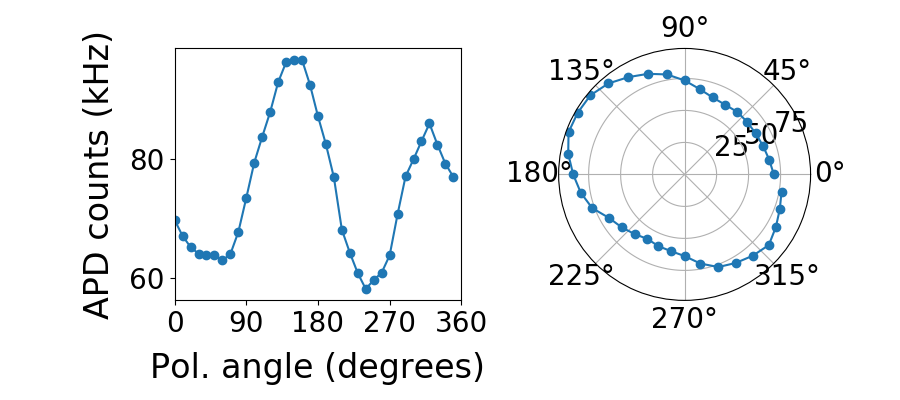

In [57]:
"""#######################################   Default parameters   #########################################"""
terminal = "/Dev1/PFI5"   # APD that has the HWP and polarizer in front
ang_step = 10
collection_time = 1   #seconds
"""#########################################################################################################"""
offset = offset_col if mode_choice.value == 'Collection' else 0

lp = LivePlot(2, 1, 9, 4, 'o', 'Pol. angle (degrees)', 'APD counts (kHz)')

pos, cts = [], []
for p in np.arange(0, 370, ang_step):
    try:
        # move HWP to new position
        hwp[mode_choice.value].mAbs((p+offset)/2)
        # collect the APD count rate
        APD1 = APDCounter(terminal, task_name='Pol counts')
        APD1.start()
        time.sleep(collection_time)
        APD_cts = APD1.read() / collection_time / 1000
        APD1.close()
        # get the new data and update the plot
        pos.append(p)
        cts.append(APD_cts)
        lp.plot_live(pos, cts)
    except KeyboardInterrupt:
        # press the stop button to trigger this
        APD1.close()
        break

lp.ax1.set_xlim([0, 360])
lp.ax1.set_xticks(np.arange(0,370,90))

if savedata_choice.value:
    data_type = 'PLvsTheta'
    data_header = "%s HWP angle (degrees)     APD counts (kHz)" % (mode_choice.value,)
    data_array = np.array([pos, cts]).T
    data_save(data_array, lp.fig, data_type, data_header)


# Run this to shut down the connection with the drivers

In [59]:
hwp['Absorption'].cleanUpAPT()
hwp['Collection'].cleanUpAPT()

In [41]:
offset

0